In [2]:
#import
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

#PATH dove andare a leggere e a scrivere
PATH_TO_WRITE_ETL = "./dataset_modificato/"
PATH_FROM_READ_ETL = "./dataset_originale/"
PATH_FROM_READ_ANALYSIS = "./dataset_modificato/" 

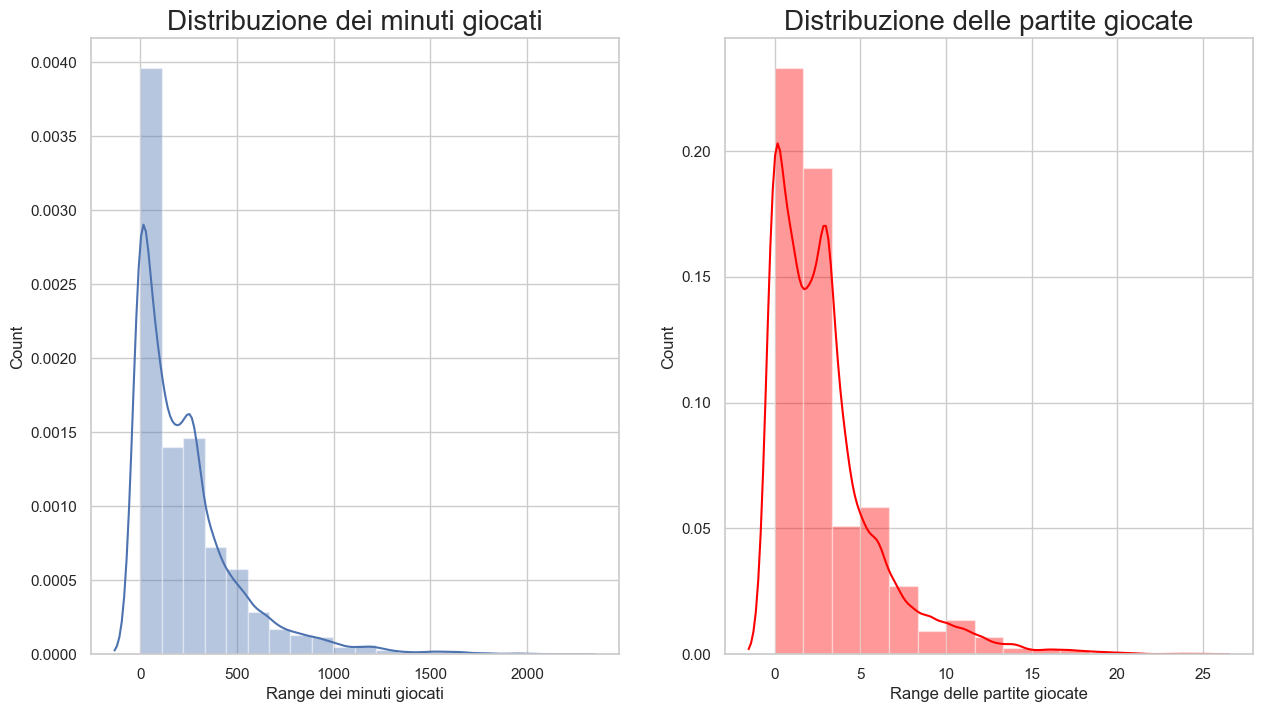

In [20]:
df_player_stats = pd.read_csv("./stats_players.csv")
#df_player_stats = df_player_stats[df_player_stats['n_minutes_played']>0]
plt.figure(figsize=(15,8))
plt.subplot(1, 2, 1)
sns.set(style = 'whitegrid')
sns.distplot(df_player_stats['n_minutes_played'], kde=True, bins=20)
plt.title('Distribuzione dei minuti giocati', fontsize = 20)
plt.xlabel('Range dei minuti giocati')
plt.ylabel('Count')


plt.subplot(1, 2, 2)
sns.set(style = 'whitegrid')
sns.distplot(df_player_stats['total_games_played'], color = 'red',kde=True, bins=15)
plt.title('Distribuzione delle partite giocate', fontsize = 20)
plt.xlabel('Range delle partite giocate')
plt.ylabel('Count')
plt.show()

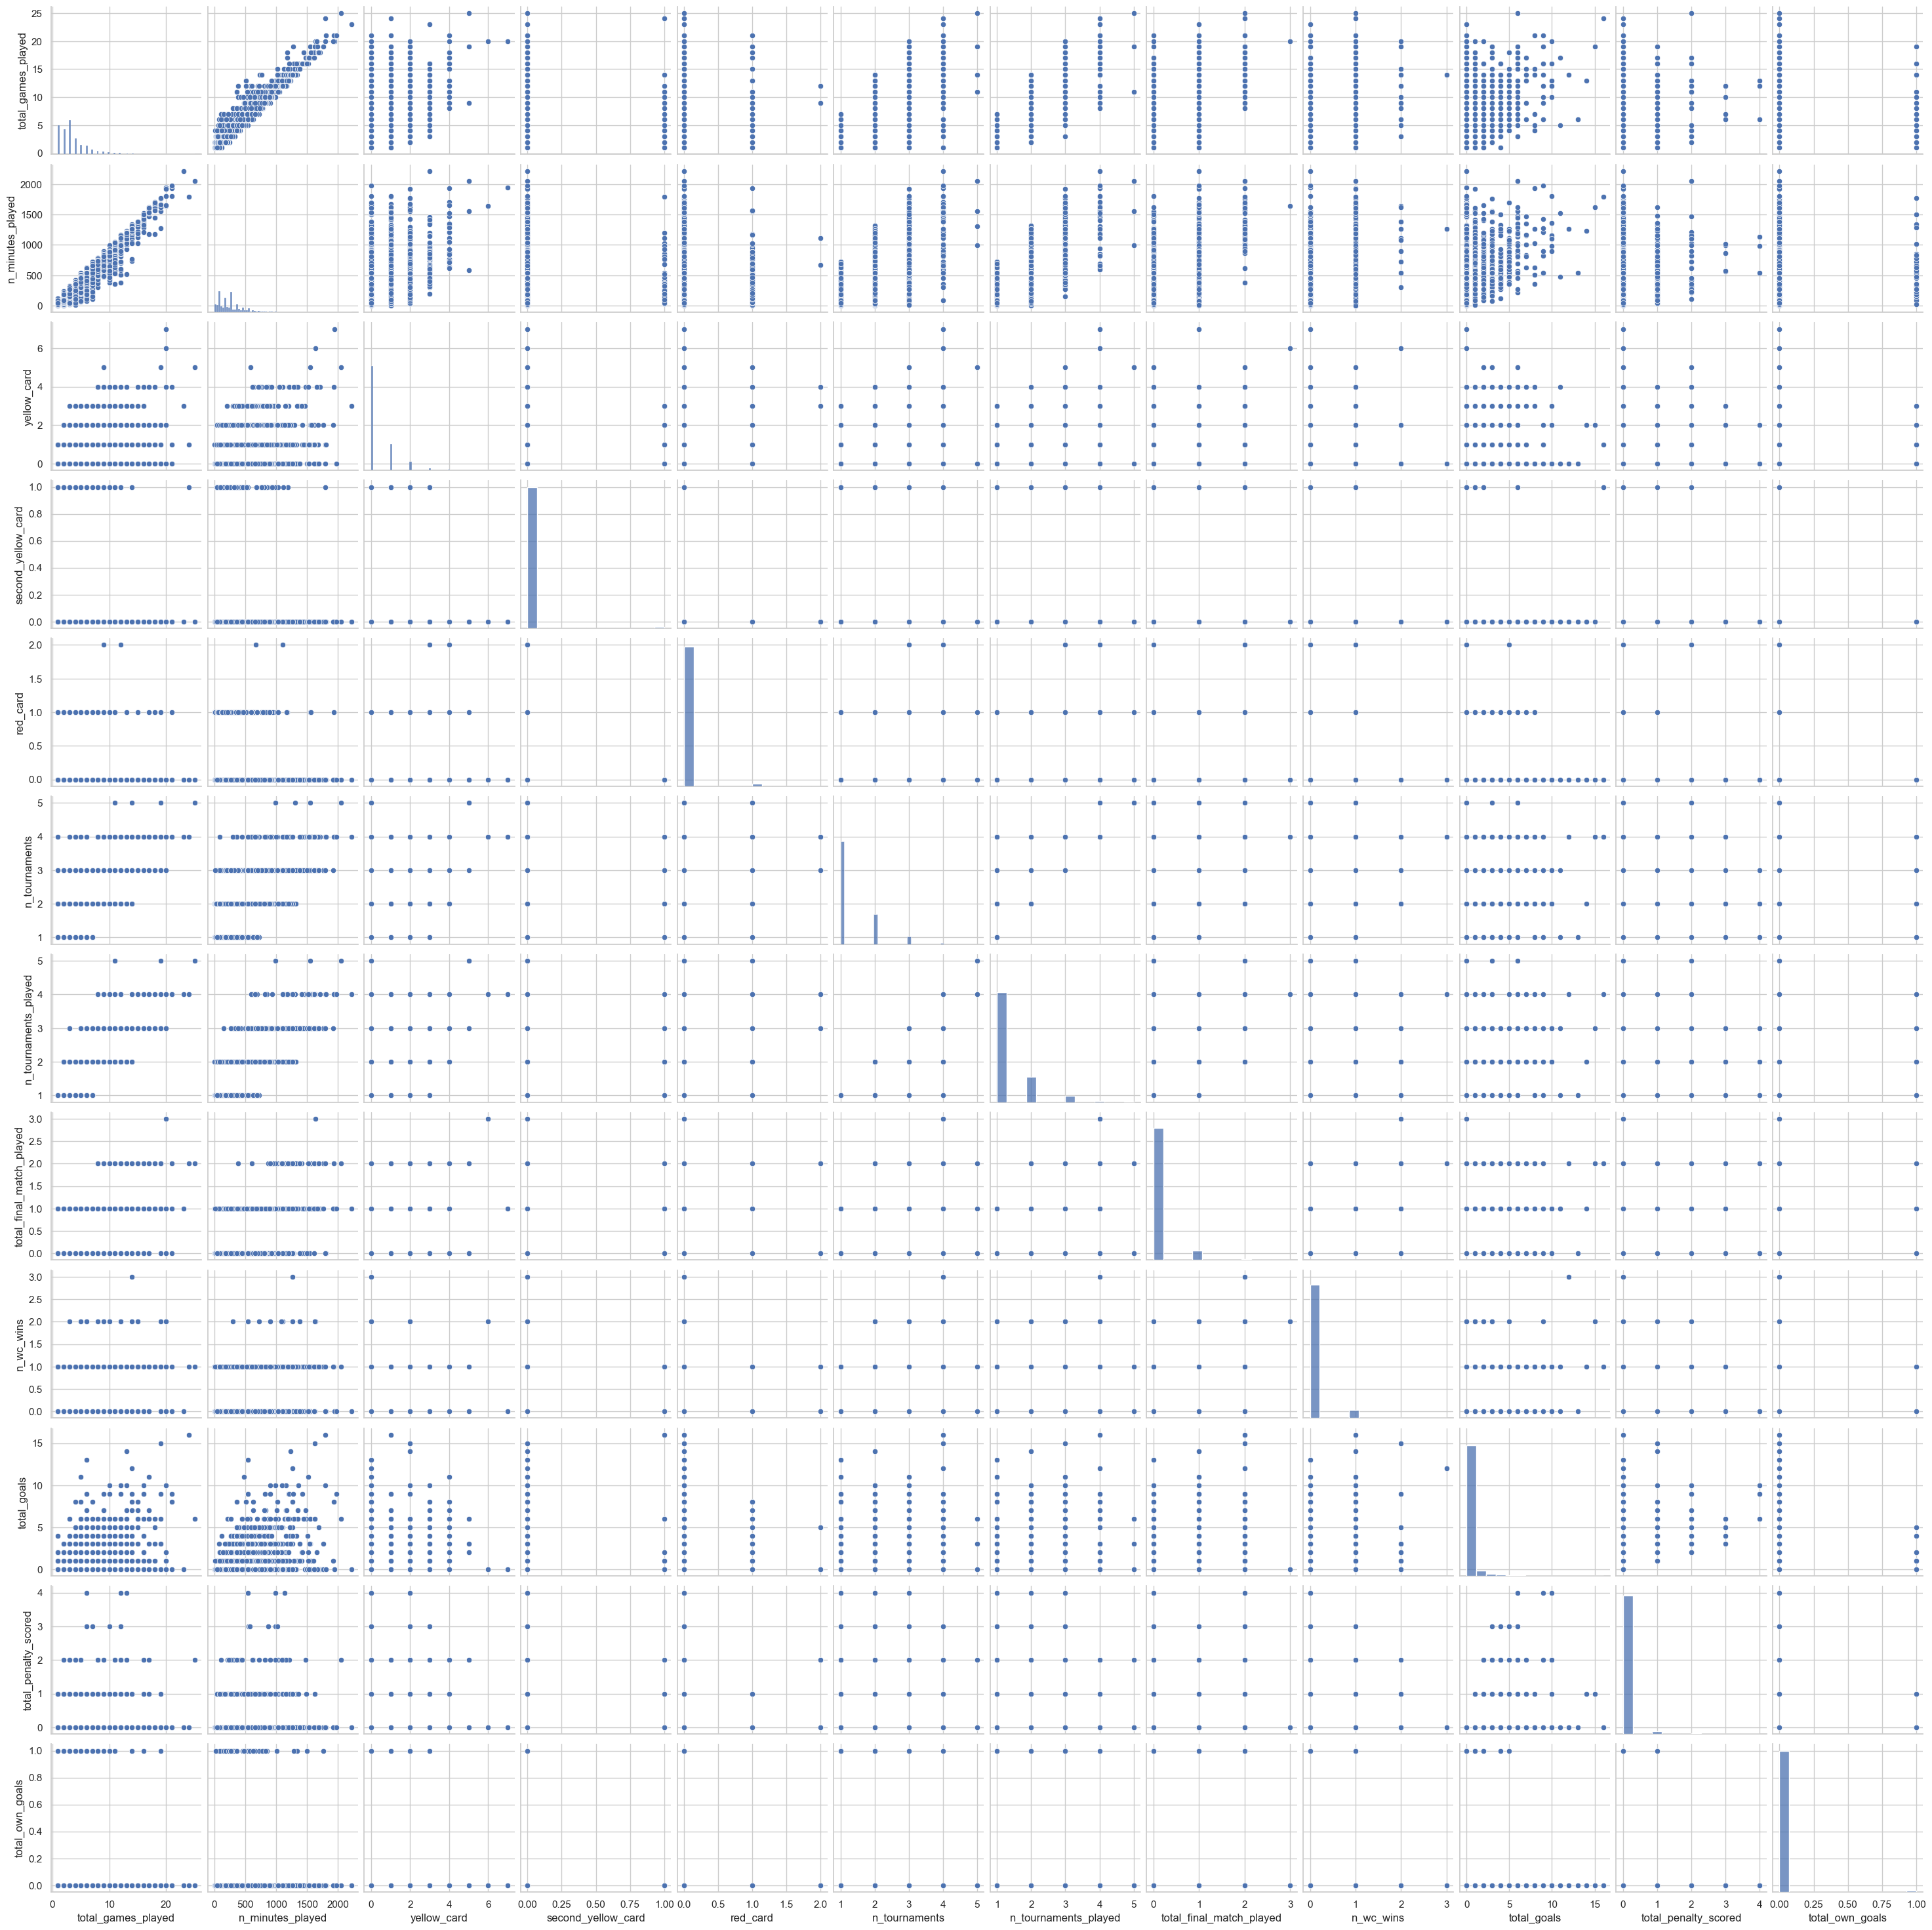

In [16]:
sns.pairplot(df_player_stats.drop(["player_id"], axis=1))

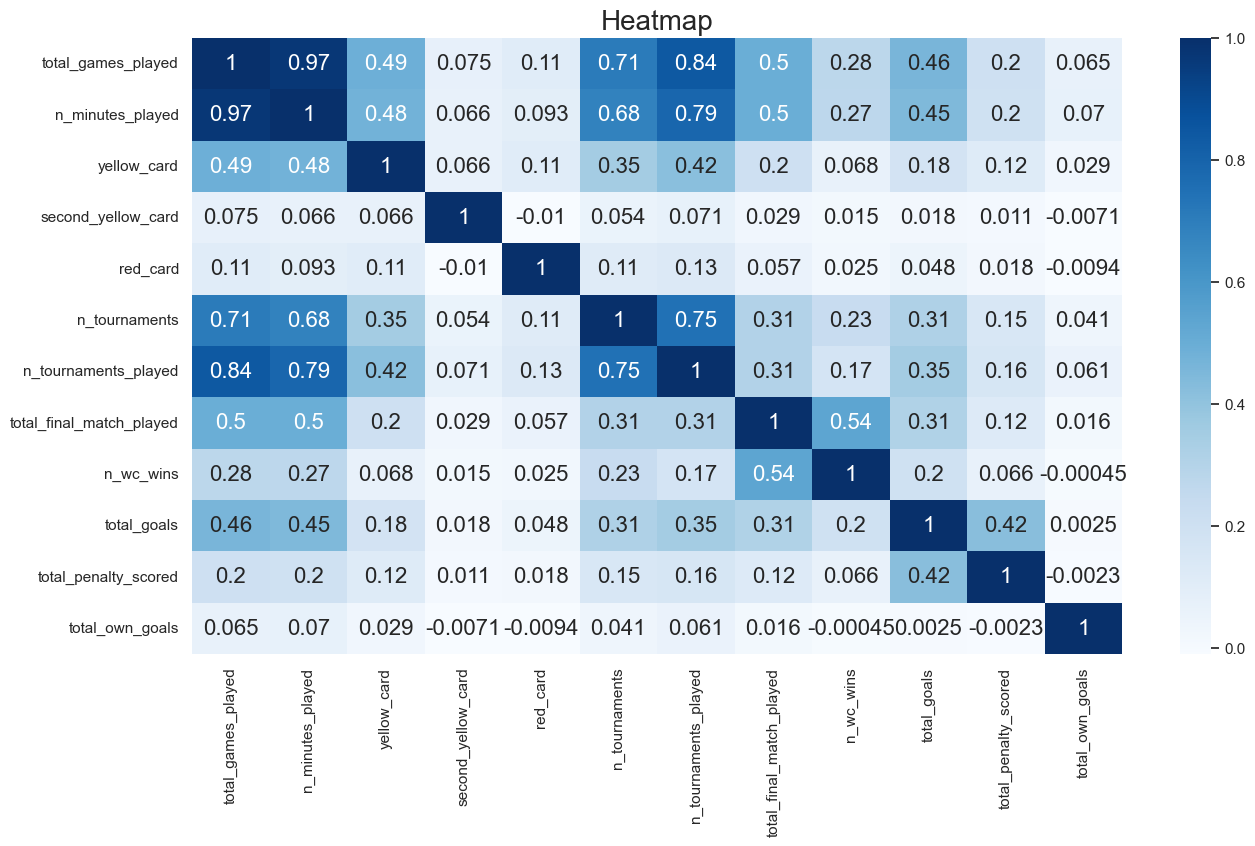

In [21]:
plt.figure(figsize=(15,8))
sns.heatmap(df_player_stats.drop(["player_id"], axis=1).corr(), cmap = 'Blues', annot = True, annot_kws={"fontsize": 16})
plt.title('Heatmap', fontsize = 20)
plt.show()
